In [593]:
from scipy.optimize import root_scalar, fsolve, minimize
import numpy as np
import math

from sim import EulerRichardson
from sim import G7, G1, solve_ode
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.optimize import minimize_scalar
from prettytable import PrettyTable
import pandas as pd

def projectile(t,y,b):
  x, y, vx, vy = y
  speed = np.sqrt(vx**2 + vy**2)

  g = b.g
  drag = b.get_drag(speed)

  u_x = vx / speed if speed != 0 else 0
  u_y = vy / speed if speed != 0 else 0

  ax = -drag * u_x
  ay = g - drag * u_y

  return np.array([vx, vy, ax, ay])

def plot_reference():
    plt.figure(figsize=(5, 3))
    plt.plot(G1[:, 0], G1[:, 1], 'black', label='G1')
    plt.plot(G7[:, 0], G7[:, 1], 'r-', label='G7')
    plt.axvline(x=1.0, color='k', linestyle='--', label='Speed of Sound')
    plt.ylabel('Cd')
    plt.xlabel('Mach Number')
    plt.title('Reference Projectiles')
    plt.legend()
    plt.grid(True)

class BallisticModel:
    def __init__(self, bc, position, velocity, reference, manufacturer_data, units="imperial"):
        # nothing need to be done to these
        self.units = units
        self.reference = reference
        self.man_x, self.man_v, self.man_y = manufacturer_data

        # initial position and velocity data
        # assumed to not need conversion
        self.x0, self.y0, = position
        self.vx0, self.vy0 = velocity

        # need unit conversions or additional work
        self.bc = self._get_bc(bc)
        self.rho = self._get_rho()
        self.vs = self._get_vs()
        self.g = self._get_g()
        self.cd = self._get_cd()

        # last simulation state
        self.x, self.y = None, None
        self.vx, self.vy = None, None

    def solve_trajectory(self):
        y0 = np.array([self.x0, self.y0, self.vx0, self.vy0])
        _, state = solve_ode(projectile, (0, 1.7), y0, EulerRichardson, self)
        self.x, self.y, self.vx, self.vy = state.T

    def sight(self, target=500):
        x = target
        y = 0

        def error_function(theta):
            v0 = np.sqrt(self.vx0**2 + self.vy0**2)
            self.vx0 = v0 * np.cos(theta.item())
            self.vy0 = v0 * np.sin(theta.item())

            self.solve_trajectory()

            idx = np.argmin(np.abs(self.x - x))
            return self.y[idx] - y

        initial_guess = np.arctan2(self.vy0, self.vx0)

        optimal = fsolve(error_function, initial_guess)[0]

        v0 = np.sqrt(self.vx0**2 + self.vy0**2)
        self.vx0 = v0 * np.cos(optimal)
        self.vy0 = v0 * np.sin(optimal)

        self.solve_trajectory()

    def optimize(self):
        def total_y_error(theta):
            v0 = np.sqrt(self.vx0**2 + self.vy0**2)

            vx_test = v0 * np.cos(theta)
            vy_test = v0 * np.sin(theta)

            y0 = np.array([self.x0, self.y0, vx_test, vy_test])
            _, state = solve_ode(projectile, (0, 10), y0, EulerRichardson, self)
            x_test, y_test, _, _ = state.T

            total_error = 0

            for i in range(len(self.man_x)):
                if self.units == "imperial":
                    x_target = self.man_x[i] * 3
                    y_man = self.man_y[i] / 12
                else:
                    x_target = self.man_x[i]
                    y_man = self.man_y[i]

                if x_target > max(x_test):
                    continue

                idx = np.argmin(np.abs(x_test - x_target))
                total_error += (y_test[idx] - y_man) ** 2
            print(total_error)
            return total_error

        result = minimize_scalar(total_y_error, bounds=(0, np.radians(15)), method='bounded')
        optimal_theta = result.x
        v0 = np.sqrt(self.vx0**2 + self.vy0**2)
        self.vx0 = v0 * np.cos(optimal_theta)
        self.vy0 = v0 * np.sin(optimal_theta)

        print(f"Optimal angle: {np.degrees(optimal_theta):.2f} degrees")

        self.solve_trajectory()

    def _get_bc(self, bc):
        if self.units == "metric":
            return bc * 0.703 #            lb/in^2 to kg/m^2
        if self.units == "imperial":
            return bc * 144                # lb/in^2 to lb/ft^2

    def _get_rho(self):
        if self.units == "metric":
            return 1.225
        if self.units == "imperial":
            return 0.0742

    def _get_vs(self):
        if self.units == "metric":
            return 343.0
        if self.units == "imperial":
            return 1125.0

    def _get_g(self):
        if self.units == "metric":
            return -9.81
        if self.units == "imperial":
            return -32.17

    def _get_cd(self):
        return interp1d(self.reference[:, 0], self.reference[:, 1], bounds_error=False, fill_value="extrapolate")

    def get_drag(self, speed):
        mach = speed / self.vs
        cd = self.cd(mach)
        drag = 0.5 * (1 / self.bc) * self.rho * speed**2 * cd
        return drag

    def plot_velocity(self):
        if self.units == "imperial":
            x = self.x / 3
            vel = self.vx
            x_unit, y_unit = "(yards)", "(ft/s)"
        else:
            x = self.x * 1000
            vel = self.vx
            x_unit, y_unit = "(m)", "(m/s)"

        plt.figure()
        plt.plot(x, vel, 'r-', label='Simulated Velocity')
        plt.scatter(self.man_x, self.man_v, color='black', s=10, label='Manufacturer Data')
        plt.xlabel("Distance " + x_unit)
        plt.ylabel("Velocity " + y_unit)
        plt.legend()
        plt.grid()
        plt.show()

    def plot_position(self):
        if self.units == "imperial":
            x = self.x / 3
            y = self.y * 12
            y_unit, x_unit = "(in)", "(yards)"
        else:
            x = self.x * 1000
            y = self.y
            y_unit, x_unit = "(m)", "(m)"

        plt.figure()
        plt.plot(x, y, 'b-', label='Simulated Path')
        plt.scatter(self.man_x, self.man_y, color='b', s=10, label='Manufacturer Data')
        plt.xlabel("Distance " + x_unit)
        plt.ylabel("Trajectory " + y_unit)
        plt.legend()
        plt.grid()
        plt.show()

    def print_errors(self):
        distances = []
        man_y_values = []
        y_errors = []
        man_vx_values = []
        vx_errors = []

        for i in range(len(self.man_x)):
            x_target = self.man_x[i] * 3

            if x_target > max(self.x):
                continue

            idx = np.argmin(np.abs(self.x - x_target))
            y_sim = self.y[idx] * 12
            vx_sim = self.vx[idx]

            y_man = self.man_y[i]
            vx_man = self.man_v[i]

            y_diff = y_sim - y_man
            vx_diff = vx_sim - vx_man

            distances.append(f"{self.man_x[i]:.0f}")
            man_y_values.append(f"{y_man:.3f}")
            y_errors.append(f"{y_diff:.3f}")
            man_vx_values.append(f"{vx_man:.3f}")
            vx_errors.append(f"{vx_diff:.3f}")

        table = PrettyTable()
        table.field_names = ["Distance (yards)"] + distances
        table.add_row(["Drop (in)"] + man_y_values)
        table.add_row(["Drop Error (in)"] + y_errors)
        table.add_row(["Speed (ft/s)"] + man_vx_values)
        table.add_row(["Speed Error (ft/s)"] + vx_errors)

        print(table)

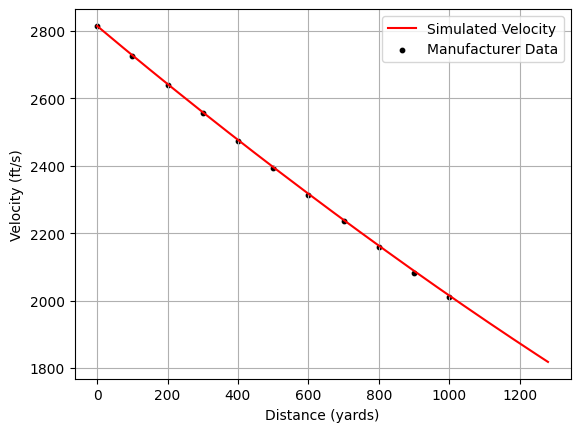

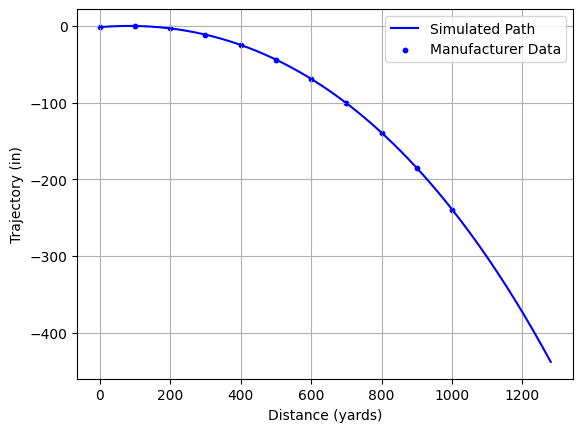

In [594]:
manufacturer_data = (
    np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]),
    np.array([2815, 2727, 2641, 2557, 2474, 2393, 2314, 2235, 2159, 2083, 2010]),
    np.array([-1.5,  0.0, -3.2, -11.4, -24.9, -44.0, -69.3, -101.0, -139.7, -185.9, -240.1]),
)

position = (0, -1.5 / 12)
velocity = (2815, 0)
b = BallisticModel(bc=1.05, position=position, velocity=velocity, manufacturer_data=manufacturer_data, reference=G1)

b.sight(300)
b.plot_velocity()
b.plot_position()

341801.2947716733
911581.82982335
128722.60532334042
47978.886947632294
17680.86570009742
6383.458033905383
2217.6045052368577
720.4381711918008
205.2256195965842
0.03416936608571423
0.034514693192338734
0.03459234392496459
Optimal angle: 0.06 degrees


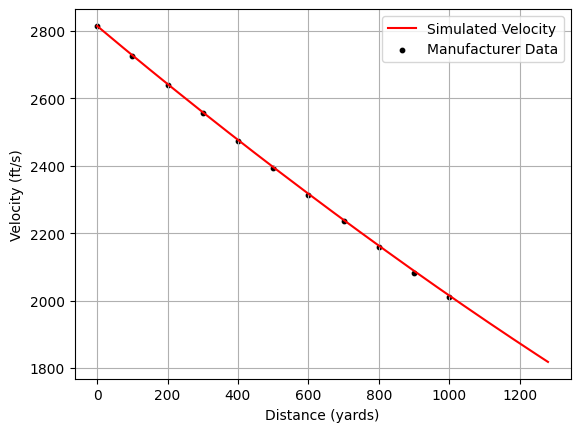

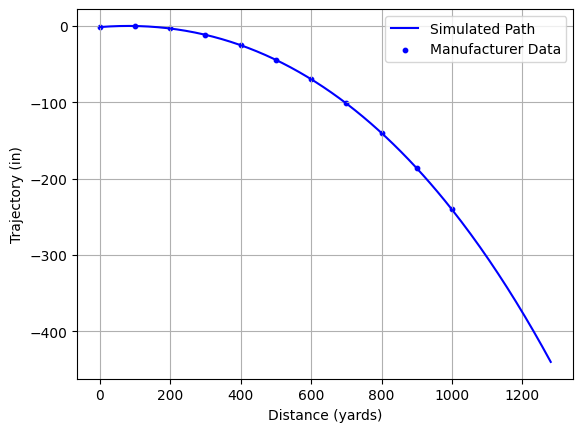

+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|  Distance (yards)  |    0     |   100    |   200    |   300    |   400    |   500    |   600    |   700    |   800    |   900    |   1000   |
+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|     Drop (in)      |  -1.500  |  0.000   |  -3.200  | -11.400  | -24.900  | -44.000  | -69.300  | -101.000 | -139.700 | -185.900 | -240.100 |
|  Drop Error (in)   |  0.000   |  -0.126  |  -0.193  |  -0.684  |  0.289   |  -0.864  |  0.656   |  -1.366  |  0.426   |  1.034   |  -0.144  |
|    Speed (ft/s)    | 2815.000 | 2727.000 | 2641.000 | 2557.000 | 2474.000 | 2393.000 | 2314.000 | 2235.000 | 2159.000 | 2083.000 | 2010.000 |
| Speed Error (ft/s) |  -0.001  |  -0.318  |  1.759   |  -1.200  |  5.973   |  1.800   |  6.142   |  2.501   |  5.760   |  7.468   |  5.

In [595]:
b.optimize()

b.plot_velocity()
b.plot_position()
b.print_errors()

340625.8318463079
909115.6906574457
128024.50527633989
47876.52409740907
17645.2096511959
6349.918271955135
2193.518563753934
703.8942170949176
0.010925318518474583
0.01112059365952823
0.011502399729736953
Optimal angle: 0.06 degrees


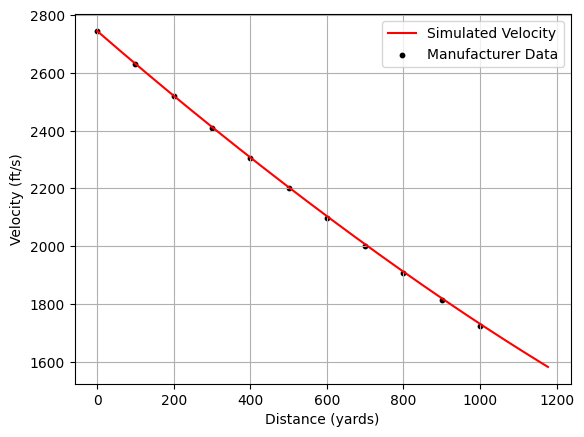

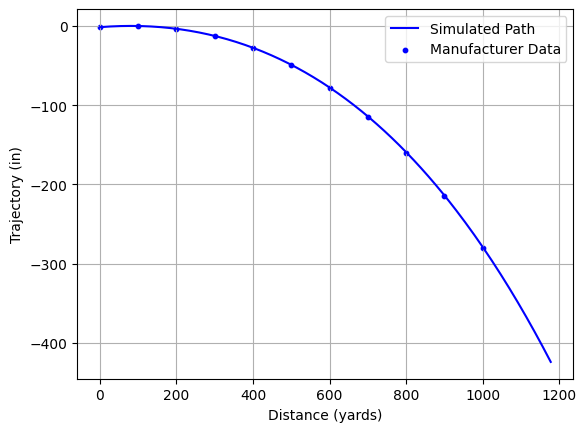

+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|  Distance (yards)  |    0     |   100    |   200    |   300    |   400    |   500    |   600    |   700    |   800    |   900    |   1000   |
+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|     Drop (in)      |  -1.500  |  0.000   |  -3.500  | -12.600  | -27.600  | -49.100  | -77.900  | -114.500 | -159.900 | -214.800 | -280.300 |
|  Drop Error (in)   |  0.000   |  -0.001  |  -0.148  |  0.021   |  -0.369  |  0.039   |  0.008   |  -1.039  |  -0.001  |  0.458   |  0.352   |
|    Speed (ft/s)    | 2745.000 | 2630.000 | 2519.000 | 2410.000 | 2304.000 | 2200.000 | 2099.000 | 2001.000 | 1906.000 | 1814.000 | 1724.000 |
| Speed Error (ft/s) |  -0.002  |  3.038   |  -0.043  |  2.438   |  0.746   |  4.308   |  4.540   |  2.414   |  4.720   |  5.380   |  6.

In [596]:
manufacturer_data = (
    np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]),
    np.array([2745, 2630, 2519, 2410, 2304, 2200, 2099, 2001, 1906, 1814, 1724]),
    np.array([-1.5,  0.0, -3.5, -12.6, -27.6, -49.1, -77.9, -114.5, -159.9, -214.8, -280.3]),
)

position = (0, -1.5 / 12)
velocity = (2745, 0)
b = BallisticModel(bc=0.789, position=position, velocity=velocity, manufacturer_data=manufacturer_data, reference=G1)

b.optimize()
b.solve_trajectory()

b.plot_velocity()
b.plot_position()
b.print_errors()

340625.8318463079
909115.6906574457
128024.50527633989
47876.52409740907
17645.2096511959
6349.918271955135
2193.518563753934
703.8942170949176
0.010925318518474583
0.01112059365952823
0.011502399729736953
Optimal angle: 0.06 degrees


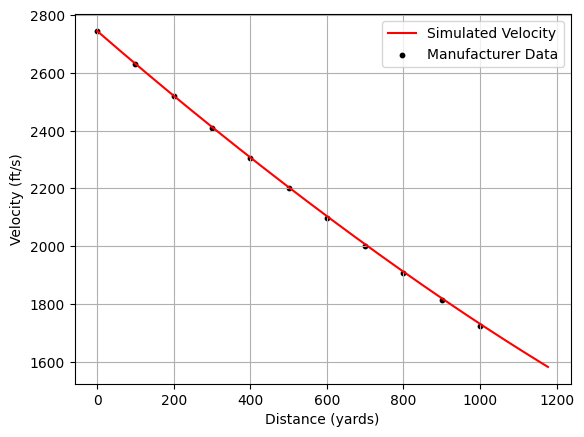

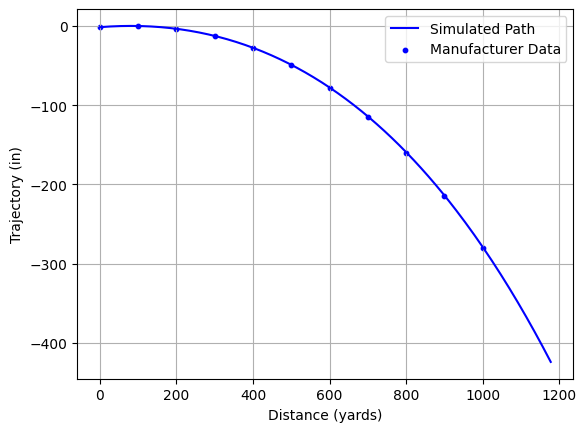

+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|  Distance (yards)  |    0     |   100    |   200    |   300    |   400    |   500    |   600    |   700    |   800    |   900    |   1000   |
+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|     Drop (in)      |  -1.500  |  0.000   |  -3.500  | -12.600  | -27.600  | -49.100  | -77.900  | -114.500 | -159.900 | -214.800 | -280.300 |
|  Drop Error (in)   |  0.000   |  -0.001  |  -0.148  |  0.021   |  -0.369  |  0.039   |  0.008   |  -1.039  |  -0.001  |  0.458   |  0.352   |
|    Speed (ft/s)    | 2745.000 | 2630.000 | 2519.000 | 2410.000 | 2304.000 | 2200.000 | 2099.000 | 2001.000 | 1906.000 | 1814.000 | 1724.000 |
| Speed Error (ft/s) |  -0.002  |  3.038   |  -0.043  |  2.438   |  0.746   |  4.308   |  4.540   |  2.414   |  4.720   |  5.380   |  6.

In [597]:
manufacturer_data = (
    np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]),
    np.array([2745, 2630, 2519, 2410, 2304, 2200, 2099, 2001, 1906, 1814, 1724]),
    np.array([-1.5,  0.0, -3.5, -12.6, -27.6, -49.1, -77.9, -114.5, -159.9, -214.8, -280.3]),
)

position = (0, -1.5 / 12)
velocity = (2745, 0)
b = BallisticModel(bc=0.789, position=position, velocity=velocity, manufacturer_data=manufacturer_data, reference=G1)

b.optimize()
b.solve_trajectory()

b.plot_velocity()
b.plot_position()
b.print_errors()

341737.63151940715
909349.3994490422
128523.13526950122
48059.0317920996
17755.203852182098
6415.729254873076
2243.4564773355573
733.6066827131577
212.11124870348937
0.09023112862093437
0.0874379788492948
0.08771537417854554
0.08792998476354241
Optimal angle: 0.06 degrees


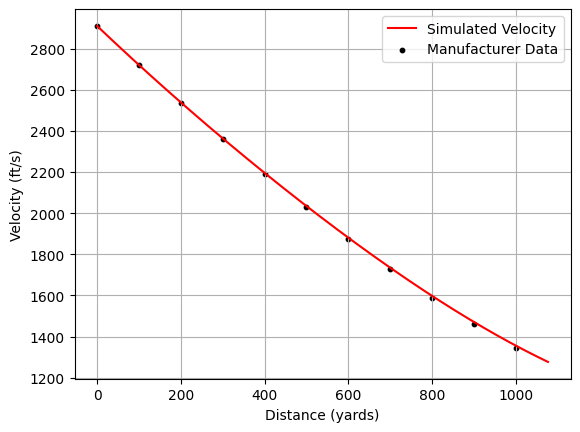

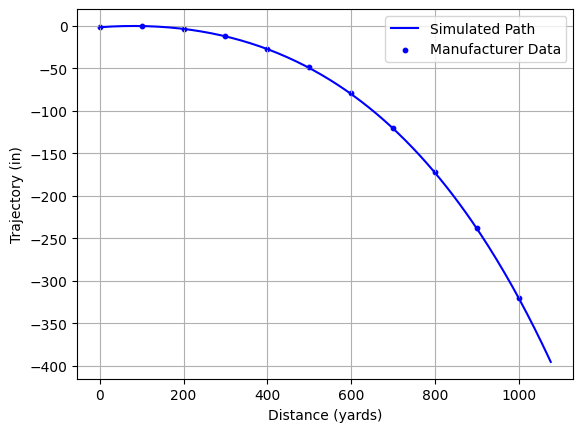

+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|  Distance (yards)  |    0     |   100    |   200    |   300    |   400    |   500    |   600    |   700    |   800    |   900    |   1000   |
+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|     Drop (in)      |  -1.500  |  0.000   |  -3.200  | -11.800  | -26.700  | -48.900  | -79.500  | -120.100 | -172.300 | -238.300 | -320.600 |
|  Drop Error (in)   |  0.000   |  -0.188  |  -0.280  |  -0.183  |  0.085   |  -1.152  |  -0.572  |  -1.478  |  -1.427  |  0.778   |  2.441   |
|    Speed (ft/s)    | 2910.000 | 2719.000 | 2535.000 | 2359.000 | 2190.000 | 2028.000 | 1874.000 | 1727.000 | 1590.000 | 1462.000 | 1347.000 |
| Speed Error (ft/s) |  -0.001  |  -4.391  |  4.551   |  9.005   |  11.645  |  3.271   |  7.027   |  4.910   |  5.515   |  10.518  |  11

In [598]:
# 6.5 Creedmoor

manufacturer_data = (
    np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]),
    np.array([2910, 2719, 2535, 2359, 2190, 2028, 1874, 1727, 1590, 1462, 1347]),
    np.array([-1.5, 0, -3.2, -11.8, -26.7, -48.9, -79.5, -120.1, -172.3, -238.3, -320.6]),
)


position = (0, -1.5 / 12)
velocity = (2910, 0)
b = BallisticModel(bc=0.486, position=position, velocity=velocity, manufacturer_data=manufacturer_data, reference=G1)

b.optimize()
b.solve_trajectory()

b.plot_velocity()
b.plot_position()
b.print_errors()

189666.03622852959
504495.7030051811
70932.08674994233
26502.726662153713
9753.728026303379
3501.549161980161
1204.4685786388561
383.49220064238466
0.04798946543126603
0.048112898395793594
0.04829450435854436
Optimal angle: 0.06 degrees


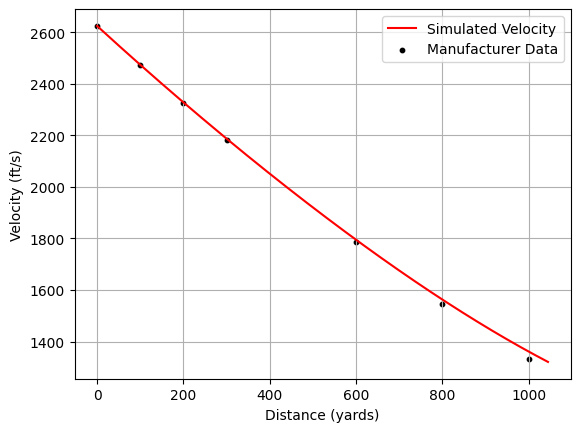

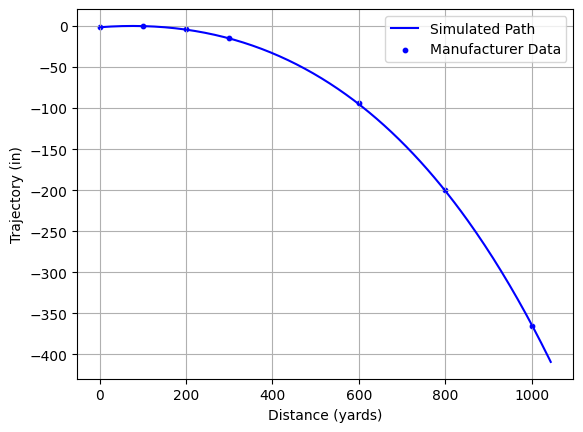

+--------------------+----------+----------+----------+----------+----------+----------+----------+
|  Distance (yards)  |    0     |   100    |   200    |   300    |   600    |   800    |   1000   |
+--------------------+----------+----------+----------+----------+----------+----------+----------+
|     Drop (in)      |  -1.600  |  0.000   |  -4.000  | -15.000  | -94.000  | -200.000 | -365.000 |
|  Drop Error (in)   |  0.000   |  -0.245  |  -0.366  |  -0.695  |  -1.194  |  -1.133  |  1.877   |
|    Speed (ft/s)    | 2625.000 | 2473.000 | 2325.000 | 2183.000 | 1786.000 | 1545.000 | 1332.000 |
| Speed Error (ft/s) |  -0.002  |  -1.585  |  6.420   |  0.043   |  8.960   |  16.894  |  29.027  |
+--------------------+----------+----------+----------+----------+----------+----------+----------+


In [599]:
man_x = np.array([0, 100, 200, 300, 600, 800, 1000])
man_v = np.array([2625, 2473, 2325, 2183, 1786, 1545, 1332])
man_y = np.array([-1.6, 0, -4, -15, -94, -200, -365])

manufacturer_data = (
    np.array([0, 100, 200, 300, 600, 800, 1000]),
    np.array([2625, 2473, 2325, 2183, 1786, 1545, 1332]),
    np.array([-1.6, 0, -4, -15, -94, -200, -365]),
)

position = (0, -1.6 / 12)
velocity = (2625, 0)
b = BallisticModel(bc=0.576, position=position, velocity=velocity, manufacturer_data=manufacturer_data, reference=G1)

b.optimize()
b.solve_trajectory()

b.plot_velocity()
b.plot_position()
b.print_errors()